### Dataset https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import random
import numpy as np
from tqdm import tqdm
import gc
from sklearn import metrics

from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
import logging

from torchsummary import summary

#add utils module to sys path
import sys
sys.path.append('../')

from utils import training, datasets
from utils.datasets import EnergyDataset

import pickle

In [3]:
print(training.Trainer())
print(EnergyDataset())

INFO:root:created trainer


In [4]:
dataset_path = './household_power_consumption.txt'
assert os.path.exists(dataset_path), f'path to dataset does not exist, path = {dataset_path}'

In [5]:
df = pd.read_csv(dataset_path, sep =';')
print(df.shape)
df.head()

(2075259, 9)


C:\Users\nguye\AppData\Local\Temp\ipykernel_14760\10537488.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path, sep =';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
df.describe()

,Sub_metering_3
count,2.049280e+06
mean,6.458447e+00
std,8.437154e+00
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.700000e+01
max,3.100000e+01


### Convert other float coumns to numbers

In [8]:
def to_float(x):
    return None if x == '?' else float(x)

for c in df.columns:
    try:
        df[c] = df[c].apply(to_float)
    except Exception as e:
        print(f"error in column {c}, error {e}")



error in column Date, error could not convert string to float: '16/12/2006'
error in column Time, error could not convert string to float: '17:24:00'


### Convert date and time column to timestamp

In [9]:
def extract_detail_datetime(datetime_fmt):
    date, time = datetime_fmt.split(' ')
    day, month, year = date.split("/")
    hour, minute, second = time.split(":")
    month = int(month)
    day = int(day)
    year = int(year)
    hour = int(hour)
    minute = int(minute)
    second = int(second)

    dt = datetime(
        month = month,
        day = day,
        year = year,
        hour = hour,
        minute = minute,
        second = second
    )

    return month, day, year, hour, minute, second, dt.timestamp()

date_time_col = df["Date"].str.cat(df['Time'], sep = ' ')
month_col, day_col, year_col, hour_col, minute_col, second_col, timestamp_col = [],[],[],[],[],[],[]

for row in date_time_col:
    month, day, year, hour, minute, second, timestamp = extract_detail_datetime(row)
    month_col.append(month)
    day_col.append(day)
    year_col.append(year)
    hour_col.append(hour)
    minute_col.append(minute)
    second_col.append(second)
    timestamp_col.append(timestamp)


df['Month'] = month_col
df['Day'] = day_col
df['Year'] = year_col
df['Hour'] = hour_col
df['Minute'] = minute_col
df['Timestamp'] = timestamp_col

In [10]:
nacount = df.isna().sum()
percent = (df.isna().sum() / df.shape[0]) * 100.0

missing = pd.concat([nacount, percent], axis = 1).rename(columns = {0:'Missing', 1:'Percentage'})
print(missing)


                       Missing  Percentage
Date                         0    0.000000
Time                         0    0.000000
Global_active_power      25979    1.251844
Global_reactive_power    25979    1.251844
Voltage                  25979    1.251844
Global_intensity         25979    1.251844
Sub_metering_1           25979    1.251844
Sub_metering_2           25979    1.251844
Sub_metering_3           25979    1.251844
Month                        0    0.000000
Day                          0    0.000000
Year                         0    0.000000
Hour                         0    0.000000
Minute                       0    0.000000
Timestamp                    0    0.000000


### Dropping NA values since they don't take up too much of the dataset

In [11]:
df = df.dropna()
#check NAs again
nacount = df.isna().sum()
percent = (df.isna().sum() / df.shape[0]) * 100.0

missing = pd.concat([nacount, percent], axis = 1).rename(columns = {0:'Missing', 1:'Percentage'})
print(missing)

                       Missing  Percentage
Date                         0         0.0
Time                         0         0.0
Global_active_power          0         0.0
Global_reactive_power        0         0.0
Voltage                      0         0.0
Global_intensity             0         0.0
Sub_metering_1               0         0.0
Sub_metering_2               0         0.0
Sub_metering_3               0         0.0
Month                        0         0.0
Day                          0         0.0
Year                         0         0.0
Hour                         0         0.0
Minute                       0         0.0
Timestamp                    0         0.0


In [12]:
print(df.shape)
df.head(100)

(2049280, 15)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,16,2006,17,24,1.166308e+09
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,16,2006,17,25,1.166308e+09
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,16,2006,17,26,1.166308e+09
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,16,2006,17,27,1.166308e+09
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,16,2006,17,28,1.166308e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16/12/2006,18:59:00,4.224,0.090,231.96,18.2,0.0,1.0,16.0,12,16,2006,18,59,1.166314e+09
96,16/12/2006,19:00:00,4.070,0.088,231.99,17.4,0.0,1.0,17.0,12,16,2006,19,0,1.166314e+09
97,16/12/2006,19:01:00,3.612,0.090,232.36,15.6,0.0,2.0,16.0,12,16,2006,19,1,1.166314e+09
98,16/12/2006,19:02:00,3.458,0.090,232.71,14.8,0.0,1.0,17.0,12,16,2006,19,2,1.166314e+09


### EDA

In [13]:
print(df.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Month', 'Day', 'Year', 'Hour', 'Minute',
       'Timestamp'],
      dtype='object')


In [14]:
display_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2','Sub_metering_3']

In [ ]:
group_by_year = df.groupby('Year')[display_cols].sum()
row_n = 4
col_n = 2

fig, axes = plt.subplots(row_n,col_n, figsize = (15,20))

for row in range(row_n):
    for col in range(col_n):
        i = row * col_n + col
        print(i)
        if i >= len(display_cols): break
        ax = axes[row][col]

        sns.lineplot(group_by_year[display_cols[i]], ax = ax)
        ax.set_xticks(list(group_by_year.index))
        ax.set_title(f"{display_cols[i]} by Year")
plt.show()
group_by_year.head()

In [16]:
group_by_month = df.groupby(['Year', 'Month'])[display_cols].sum()

# sns.lineplot(group_by_month.loc['2007']['Global_active_power'])
# print(group_by_month[df['Year']])
# print(group_by_month.index)
year_col, month_col = [],[]

for year, month in group_by_month.index:
    year_col.append(year)
    month_col.append(month)

group_by_month['Year'] = year_col 
group_by_month['Month'] = month_col 

group_by_month.head(20)


Global_active_power  Global_reactive_power      Voltage  \
Year Month                                                            
2006 12               41813.282               2889.436   5309773.22   
2007 1                69011.862               5922.396  10753521.91   
     2                56488.886               4581.608   9697260.78   
     3                58862.192               5122.184  10736280.75   
     4                35181.466               4688.994   9450794.83   
     5                44008.872               5148.894  10498362.16   
     6                35682.828               6317.980  10309151.25   
     7                29703.830               5674.062  10578509.55   
     8                34096.460               5033.644  10616283.84   
     9                41872.606               5443.416  10342642.60   
     10               49276.370               4171.170  10700881.41   
     11               55918.644               4170.904  10405070.38   
     12               72604.170               4950.484  10790396.33   
2008 1                65169.382               3908.238  10742211.50   
     2                49331.072               3639.688  10046857.96   
     3                55590.594               4531.466  10772523.43   
     4                48209.992               5361.760  10420755.46   
     5                45721.860               6896.588  10729543.15   
     6                42943.972               6550.438  10323489.14   
     7                35477.418               6551.446  10702890.14   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Year Month                                                                     
2006 12             176594.8         27460.0         48712.0        162951.0   
2007 1              292241.2         56433.0         79274.0        329578.0   
     2              238463.6         47584.0         64604.0        270274.0   
     3              248772.2         60769.0        104762.0        290361.0   
     4              151026.2         42078.0         38417.0        189503.0   
     5              191838.8         75737.0         72132.0        229448.0   
     6              155518.4         59672.0         69939.0        188851.0   
     7              131040.4         43052.0         55733.0        154815.0   
     8              147804.6         36251.0         49711.0        225442.0   
     9              180334.8         52841.0         75277.0        226375.0   
     10             208779.8         43218.0         87914.0        256080.0   
     11             235253.8         50823.0         73666.0        299690.0   
     12             304418.2         74090.0         82931.0        362423.0   
2008 1              275945.6         61761.0         62911.0        312175.0   
     2              207710.2         40192.0         56646.0        255918.0   
     3              233677.6         63110.0         79277.0        279670.0   
     4              202913.0         47080.0         70871.0        295678.0   
     5              195697.2         53084.0         58907.0        290620.0   
     6              185819.0         68728.0         63449.0        290103.0   
     7              154611.8         47313.0         44416.0        227228.0   

            Year  Month  
Year Month               
2006 12     2006     12  
2007 1      2007      1  
     2      2007      2  
     3      2007      3  
     4      2007      4  
     5      2007      5  
     6      2007      6  
     7      2007      7  
     8      2007      8  
     9      2007      9  
     10     2007     10  
     11     2007     11  
     12     2007     12  
2008 1      2008      1  
     2      2008      2  
     3      2008      3  
     4      2008      4  
     5      2008      5  
     6      2008      6  
     7      2008      7

Text(0.5, 1.0, 'Globale Active Power by Month for Every Year')

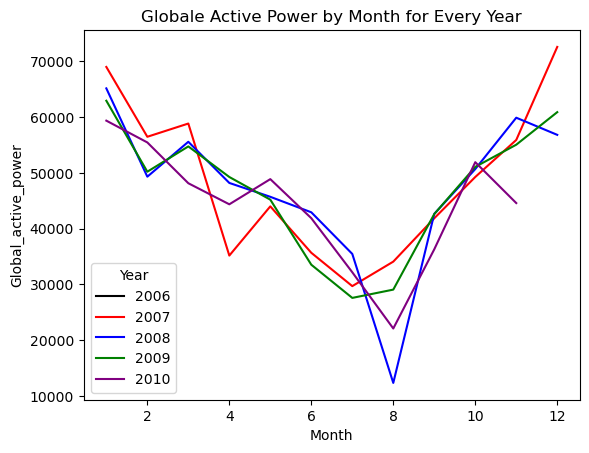

In [17]:
sns.lineplot(data = group_by_month, x = 'Month', y ='Global_active_power', hue = 'Year', palette=['black', 'red', 'blue', 'green', 'purple'])
plt.title("Globale Active Power by Month for Every Year")

In [18]:
print(set(df['Year']))
group_by_month.head(100)

{2006, 2007, 2008, 2009, 2010}


Global_active_power  Global_reactive_power      Voltage  \
Year Month                                                            
2006 12               41813.282               2889.436   5309773.22   
2007 1                69011.862               5922.396  10753521.91   
     2                56488.886               4581.608   9697260.78   
     3                58862.192               5122.184  10736280.75   
     4                35181.466               4688.994   9450794.83   
     5                44008.872               5148.894  10498362.16   
     6                35682.828               6317.980  10309151.25   
     7                29703.830               5674.062  10578509.55   
     8                34096.460               5033.644  10616283.84   
     9                41872.606               5443.416  10342642.60   
     10               49276.370               4171.170  10700881.41   
     11               55918.644               4170.904  10405070.38   
     12               72604.170               4950.484  10790396.33   
2008 1                65169.382               3908.238  10742211.50   
     2                49331.072               3639.688  10046857.96   
     3                55590.594               4531.466  10772523.43   
     4                48209.992               5361.760  10420755.46   
     5                45721.860               6896.588  10729543.15   
     6                42943.972               6550.438  10323489.14   
     7                35477.418               6551.446  10702890.14   
     8                12341.880               5705.046  10732450.56   
     9                42667.792               5399.154  10373381.89   
     10               50696.460               4712.902  10717968.88   
     11               59908.760               4377.654  10391188.27   
     12               56833.912               4070.958  10834008.18   
2009 1                62950.008               4396.526  10882685.36   
     2                50222.090               3858.294   9758014.49   
     3                54758.986               4657.394  10815949.79   
     4                49275.524               5314.588  10438073.71   
     5                45209.830               5337.736  10717942.42   
     6                33541.980               5429.500   9616389.45   
     7                27590.444               7487.970  10802709.17   
     8                29076.404               8243.432  10555310.81   
     9                42628.564               6648.062  10416803.52   
     10               51088.720               5866.398  10753273.24   
     11               55067.642               5473.938  10451851.03   
     12               60905.006               5791.888  10895351.04   
2010 1                59379.658               5196.072  10105594.77   
     2                55471.706               4130.218   9770991.14   
     3                48155.898               5328.960  10312056.70   
     4                44378.124               5393.432  10444775.10   
     5                48892.400               5454.214  10729839.44   
     6                41885.424               6484.718  10403886.68   
     7                32187.752               7386.890  10737823.51   
     8                22103.374               4782.076   9026141.77   
     9                36309.424               4773.662   9156874.28   
     10               51932.954               6140.416  10809749.46   
     11               44598.388               4128.708   8970019.70   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
Year Month                                                                     
2006 12             176594.8         27460.0         48712.0        162951.0   
2007 1              292241.2         56433.0         79274.0        329578.0   
     2              238463.6         47584.0         64604.0        270274.0   
     3              248772.2         60769.0        104762.0 

###  Training base RNN model 

In [19]:
#Final processed df 
print('df shape = ', df.shape)
df.head()

df shape =  (2049280, 15)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,16,2006,17,24,1.166308e+09
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,16,2006,17,25,1.166308e+09
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,16,2006,17,26,1.166308e+09
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,16,2006,17,27,1.166308e+09
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,16,2006,17,28,1.166308e+09


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049280 entries, 0 to 2075258
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
 9   Month                  int64  
 10  Day                    int64  
 11  Year                   int64  
 12  Hour                   int64  
 13  Minute                 int64  
 14  Timestamp              float64
dtypes: float64(8), int64(5), object(2)
memory usage: 250.2+ MB


In [21]:
print(df.columns)
df.describe()

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Month', 'Day', 'Year', 'Hour', 'Minute',
       'Timestamp'],
      dtype='object')


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,6.454433e+00,1.571245e+01,2.008425e+03,1.150391e+01,2.950043e+01,1.228195e+09
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,3.423209e+00,8.801670e+00,1.124388e+00,6.925189e+00,1.731790e+01,3.578735e+07
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.006000e+03,0.000000e+00,0.000000e+00,1.166308e+09
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,8.000000e+00,2.007000e+03,5.000000e+00,1.500000e+01,1.197283e+09
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.600000e+01,2.008000e+03,1.200000e+01,3.000000e+01,1.228026e+09
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,9.000000e+00,2.300000e+01,2.009000e+03,1.800000e+01,4.500000e+01,1.259026e+09
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.200000e+01,3.100000e+01,2.010000e+03,2.300000e+01,5.900000e+01,1.290823e+09


In [22]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Month,Day,Year,Hour,Minute,Timestamp
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,12,16,2006,17,24,1.166308e+09
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,12,16,2006,17,25,1.166308e+09
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,12,16,2006,17,26,1.166308e+09
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,12,16,2006,17,27,1.166308e+09
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,12,16,2006,17,28,1.166308e+09


### Splitting dataset to train, valid, test

### Experiments
1. dropping month, day, hour, minute and use timestamp instead
2. normalize the columns
3. set the timestep to 100

### Baseline

In [23]:
# #Split train test
# x_train, x_valid_test, y_train, y_valid_test = train_test_split(features, labels, random_state = 42, shuffle = True)
# x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test, y_valid_test, random_state = 42, shuffle = True, test_size = 0.5)

# print("X train shape = ", x_train.shape)
# print("y train shape = ", y_train.shape)
# print("X valid shape = ", x_valid.shape)
# print("y valid shape = ", y_valid.shape)
# print("X test shape = ", x_test.shape)
# print("y test shape = ", y_test.shape)

In [25]:
target = 'Voltage'
cols = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Month', 'Day', 'Year', 'Hour', 'Minute']
dataset = EnergyDataset(df[:100000], target = target, cols = cols)
print(len(dataset))

INFO:root:building sequences ... 
100%|██████████| 99900/99900 [00:04<00:00, 23203.72it/s]
INFO:root:done building sequences
DEBUG:root:X shape =  torch.Size([99900, 100, 11])
DEBUG:root:y shape =  torch.Size([99900])


99900


In [26]:
with open('dataset.pkl', 'wb') as file:
    pickle.dump(dataset, file)
    

In [30]:
train_dataloader = dataset.get_dataloader(batch_size = 32)
print(len(train_dataloader))
X, y = next(iter(train_dataloader))
print(f'X shape=  {X.shape}, dtype = {X.dtype}')
print(f'y shape=  {y.shape}, dtype = {y.dtype}')

3122
X shape=  torch.Size([32, 100, 11]), dtype = torch.float32
y shape=  torch.Size([32]), dtype = torch.float32


In [2]:
with open('dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)

In [3]:
class SimpleRNN(nn.Module):

    def __init__(self, input_size = 10, num_hiddens = 100, num_layers = 5, num_blocks = 3, dropout = 0.5):
        super().__init__()

        self.input_size = input_size
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.num_blocks = num_blocks
        self.dropout = dropout

        self.rnn_blocks = nn.Sequential()

        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = num_hiddens,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True
            )
        
        self.dense = nn.LazyLinear(1)
    
    def forward(self, X):
        outputs, state = self.rnn(X)
        Y = self.dense(outputs[:,-1])
        return Y

In [4]:
batch_size = 32
train_dataset, valid_dataset, test_dataset = training.train_val_test_split(dataset)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
print('train dataloader len = ', len(train_dataloader))
print('valid dataloader len = ', len(valid_dataloader))
print('test dataloader len = ', len(test_dataloader))


train dataloader len =  2186
valid dataloader len =  469
test dataloader len =  469


In [42]:
class Trainer():
    def __init__(self, 
                score_fn,
                feature_dtype = torch.FloatTensor, 
                label_dtype = torch.LongTensor, 
                log_level = logging.DEBUG):
        '''
        @param:
            score_fn: sklearn.metrics, score function that use for model evaluation. e.g: accuracy for classification, MSE for regression, ... 
            feature_dtype: torch.dtype = torch.FloatTensor, feature dtype to convert during batch preperation
            label_dtype: torch.dtype = torch.LongTensor, label dtype to convert during batch preperation
            log_level: str = logging.DEBUG, set logging level
        @return:
            None
        '''
        self.feature_dtype = feature_dtype
        self.label_dtype = label_dtype
        self.score_fn = score_fn
        self.device = 'cuda' if torch.cuda.is_available() else "cpu"
        self.logger = logging.getLogger()
        self.logger.setLevel(log_level)
        self.logger.info('created trainer')

    def prepare_model(self, model, device):
        model.to(device)
        return model
    
    def prepare_batch(self, batch, device):
        '''
            convert features and labels to device
            @params:
                batch, loaded from DataLoader
                device: str, cuda or cpu
            @return:
                features: torch.tensor
                labels: torch.tensor
        '''
        features, labels = batch
        features = features.type(self.feature_dtype).to(device)
        labels = labels.type(self.label_dtype).to(device)
        return features, labels
    
    def score(self, model, dataloader, device, criterion = None, name ='', **kwargs):
        y_pred = np.array([])
        y = np.array([])
        loop = tqdm(dataloader)
        loop.set_description(f'evaluating score {name}...')
        running_loss = 0.0 if criterion != None else None
        for batch in loop: 
            features, labels = self.prepare_batch(batch, device)
            outputs = model(features)

            #get loss values if criterion not None 
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item()

            outputs = torch.argmax(outputs, dim = 1).detach().cpu().numpy().reshape(-1)
            labels = labels.detach().cpu().numpy().reshape(-1)
            y_pred = np.concatenate((y_pred, outputs))
            y = np.concatenate((y, labels))
        
        return self.score_fn(y_pred, y, **kwargs), running_loss 

    def confusion_matrix(self, model, dataloader, device, **kwwargs):
        y_pred = np.array([])
        y = np.array([])
        for batch in dataloader:
            features, labels = self.prepare_batch(batch, device)
            outputs = model(features)
            outputs = torch.argmax(outputs, dim = 1).detach().cpu().numpy().reshape(-1)
            labels = labels.detach().cpu().numpy().reshape(-1)
            y_pred = np.concatenate((y_pred, outputs))
            y = np.concatenate((y, labels))

        cm = metrics.confusion_matrix(y_pred, y)
        sns.heatmap(cm, annot = True)
    
    def performance_plot(self, history):
        train_loss =[]
        val_loss =[]
        test_loss =[]
        train_score = []
        val_score = []
        test_score = []

        for hist in history:
            train_loss.append(hist['train_loss'])
            val_loss.append(hist['val_loss'])
            test_loss.append(hist['test_loss'])
            train_score.append(hist['train_score'])
            val_score.append(hist['val_score'])
            test_score.append(hist['test_score'])
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
        e = list(range(len(history)))
        
        sns.lineplot(x = e, y = train_loss, label = 'train sco', ax = ax1)
        sns.lineplot(x = e, y = val_loss, label = 'val loss', ax = ax1)
        sns.lineplot(x = e, y = test_loss, label = 'test loss', ax = ax1)
        sns.lineplot(x = e, y = train_score, label = 'train score', ax = ax2)
        sns.lineplot(x = e, y = val_score, label = 'val score', ax = ax2)
        sns.lineplot(x = e, y = test_score, label = 'test score', ax = ax2)
        plt.show()
        

    def train(self, model, optim, criterion,  train_dataloader, val_dataloader, \
              test_dataloader, device = None, epochs = 10, save_path = None):

        if device == None:
            device = self.device

        self.logger.info(f"DEVICE = {device}")

        history = []
        self.logger.debug('preparing model for training ... ')
        model = self.prepare_model(model, device)
        self.logger.debug('model prep done')

        self.logger.info('training ... ')

        best_score = 0

        for e in range(epochs):
            loop = tqdm(train_dataloader)

            total_train_loss = 0

            model.train()

            for batch in loop:
                features, labels = self.prepare_batch(batch, device)

                outputs = model(features)

                optim.zero_grad()
                loss = criterion(outputs, labels)
                loss.backward()
                optim.step()

                total_train_loss += loss.item()

                loop.set_description(f'training epoch {e}\t train loss = {total_train_loss:.2f}')

            model.eval()
            train_accuracy, train_loss =    self.score(model, train_dataloader, device, criterion=criterion, name = 'train')
            val_accuracy, val_loss =        self.score(model, val_dataloader, device, criterion=criterion, name = 'valid')
            test_accuracy, test_loss =      self.score(model, test_dataloader, device, criterion=criterion, name = 'test')

            self.logger.debug(f'\n\
                            epoch = {e}\n\
                            =============\n\
                            train_loss = {train_loss:.2f}\n\
                            train_score = {train_accuracy:.2f}\n\
                            val score = {val_loss:.2f}\n\
                            valid_score = {val_accuracy:.2f}\n\
                            test loss = {test_loss:.2f}\n\
                            test_score = {test_accuracy:.2f}\n\
                            best_score = {best_score:.2f}\n\
                            ')
            history.append({
                'train_loss': train_loss,
                'train_score': train_accuracy,
                'val_loss': val_loss,
                'val_score': val_accuracy,
                'test_loss': test_loss,
                'test_score': test_accuracy,
            })
            
            if best_score < test_accuracy:
                best_score = test_accuracy

                if save_path:
                    self.logger.info(f"saved best score model at checkpoint.{save_path}")
                    torch.save(model, 'checkpoint.' + save_path)

        self.logger.info("done training ...")

        return model, history 

In [19]:
trainer = Trainer()

INFO:root:created trainer


In [34]:
# %load_ext autoreload
# %autoreload 2
# X = torch.rand(batch_size, timestep, input_size)
trainer = Trainer(score_fn= metrics.mean_squared_error, label_dtype=torch.FloatTensor)
X, y = next(iter(train_dataloader))
batch_size, num_steps , input_size = X.shape
model = SimpleRNN(input_size = input_size)
model = trainer.prepare_model(model, 'cuda')
X, y = trainer.prepare_batch((X,y), 'cuda')

model, history = trainer.score(model, train_dataloader, 'cuda', name = 'test')

# y_pred = model(X)
# y_pred = y_pred.squeeze(-1)
# print('y pred shape = ', y_pred.shape, ' type = ', y_pred.dtype)
# print('y shape = ', y.shape, ' type = ', y.dtype)

# optim = torch.optim.Adam(model.parameters(), lr = 0.001)
# criterion = nn.MSELoss()

# # y = y.to(torch.float32)
# loss = criterion(y_pred, y)
# print(loss.item())
# print(type(loss))
# print(loss)

# loss.backward()


INFO:root:created trainer
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
evaluating score test...: 100%|██████████| 2186/2186 [00:03<00:00, 646.76it/s]


(58011.21256611372, None)

In [50]:
model = SimpleRNN(input_size = input_size)
optim = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
trainer = Trainer(score_fn= metrics.mean_squared_error, label_dtype=torch.FloatTensor)
model, history = trainer.train(model, optim, criterion, train_dataloader, valid_dataloader, test_dataloader, epochs = 5)

c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:root:created trainer
INFO:root:DEVICE = cuda
DEBUG:root:preparing model for training ... 
DEBUG:root:model prep done
INFO:root:training ... 
  0%|          | 0/2186 [00:00<?, ?it/s]c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
training epoch 0	 train loss = 5265303.93:  99%|█████████▉| 2170/2186 [00:14<00:00, 142.89it/s]c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\module

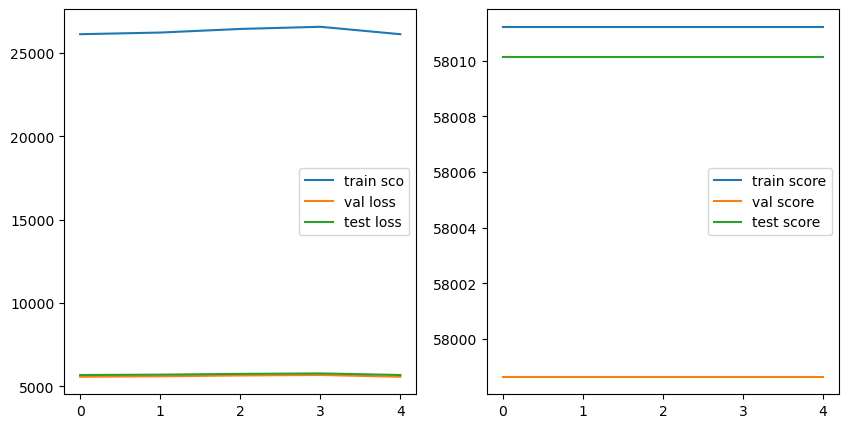

In [51]:
trainer.performance_plot(history)